# Models
## NN 
First we try a simpler NN linear model

### Things we want to investigate
"The importance of feature normalisation and selection"

- KNN:
    - In person prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA

- Linear model:
    - In person prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA
        - (Under-/Over-sampling)
    - Leave-one-person-out prediction
        - Normalized Raw
        - Unnormalized Raw
        - Normalized PCA
        - Unnormalized PCA





In [1]:
import numpy as np
import pandas as pd
import math
from src.preprocess_data import preprocess_dataset
import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from collections import deque
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dfs = preprocess_dataset( "condensed", 100, overlapping=False,)
print()

TypeError: preprocess_dataset() got an unexpected keyword argument 'overlapping'

In [ ]:
class Linear_Model(torch.nn.Module):
    def __init__(self, in_features = 16, out_features = 4, num_hidden = []) -> None:
        super().__init__()
        
        
        # Add input and output to layers
        self.num_hidden = [in_features] + num_hidden + [out_features]
        layers = []
        
        for i in range(len(self.num_hidden)-1):
            layers.append(
                torch.nn.Linear(in_features=self.num_hidden[i], out_features= self.num_hidden[i+1]))
            layers.append(torch.nn.ReLU())
            
        # Remove last ReLu
        del layers[-1]
            
    
        self.model = torch.nn.Sequential(*layers)
    
    def description(self):
        return str(self.num_hidden)
    
    def reset_parameters(self):
        for layer in self.model.children():
            if hasattr(layer,"reset_parameter"):
                layer.reset_parameters()
        
    def forward(self,x):
        return self.model(x)


def train_epoch(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, optimizer : torch.optim.Optimizer, loss_function = torch.nn.CrossEntropyLoss(), verbose = False) -> float:
    """Trains the model on the dataset

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The dataset.
        optimizer (torch.optim.Optimizer): The optimizer for the given model

    Returns:
        float: The accuraccy of the model
    """
    
    __device = next(model.parameters()).device
    model.train()
    correct, total, acc = 0,0, 0
    loss_window = deque()
    loss_window.extend([0]*5)

    
    for itr, (datas,labels) in enumerate(dataloader):
        if verbose:
            print("Training. Batch {}/{}. Running Acc: {:.2f}%     Loss window: {:.4f}".format(itr,len(dataloader), acc, sum(list(loss_window))/len(loss_window)), end = "\r")
        optimizer.zero_grad()

        # Predict
        output = model(datas.to(__device))
        
        # Metrics
        _, pred = output.cpu().max(1, keepdims=True)
        correct += pred.eq(labels).sum().item()
        total += len(datas)
        acc = correct / total * 100
        
        # Update
        loss = loss_function(output, labels.squeeze(-1))
        
        loss_window.append(loss)
        loss_window.popleft()
        
        
        loss.backward()
        optimizer.step()
        
    if verbose:
        print("Training. Batch {}/{}. Running Acc: {:.2f}%".format(itr + 1,len(dataloader), acc))
        
    return acc

def test_epoch(model : torch.nn.Module, dataloader : torch.utils.data.DataLoader, verbose = False) -> float : 
    """Evaluates the model on the dataset 

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The dataset.

    Returns:
        float: The accuraccy of the model
    """
    model.eval()
    correct, total, acc = 0,0, 0
   

    for itr, (datas,labels) in enumerate(dataloader):
        if verbose:
            print("Testing. Batch {}/{}. Running Acc: {:.2f}%".format(itr,len(dataloader), acc), end = "\r")
       
        # Predict
        output = model(datas)
        
        # Metrics
        _, pred = output.cpu().max(1, keepdims=True)
        correct += pred.eq(labels).sum().item()
        total += len(datas)
        acc = correct / total * 100
        
    if verbose:
        print("Testing. Batch {}/{}. Running Acc: {:.2f}%".format(itr + 1,len(dataloader), acc))
        
    return acc

    
def create_dataloader(datasets : dict, batch_size : int, shuffle : bool = True, undersampling: bool = True) -> torch.utils.data.DataLoader:
    """Creates a single dataloader from all data provided in datasets

    Args:
        datasets (dict): A dictionary of datasets
        batch_size (int): The batch size forwarded to the data_loader
        shuffle (bool, optional): If the samples sould be reshuffled each epoch. Defaults to True.
        undersampling (bool, optional): Wether to perform undersampling to balance the class distribution. Defaults to True.
        
    Returns:
        torch.utils.data.DataLoader: The dataloader
    """
    # Get datasets 
    datasets = list(datasets.values())
    
    # Transform to numpy
    datasets = [ds.to_numpy() if ds is pd.DataFrame else ds for ds in datasets]
    
    # Concat into single numpy matrix
    datasets = np.concatenate(datasets)
    
    # Split data from label
    data = torch.from_numpy(datasets[:,:-1].astype(np.float32))
    labels = torch.from_numpy(datasets[:,-1, None].astype(np.int64))
    
    # Construct TensorDataset
    dataloader = DataLoader(TensorDataset(data, labels), batch_size = batch_size, shuffle = shuffle, num_workers=0)
    
    return dataloader



BATCH_SIZE = 256



Model: [16, 4]
Model: [16, 10, 4]
Model: [16, 20, 4]
Model: [16, 40, 4]
Model: [16, 10, 10, 4]
Model: [16, 20, 20, 4]
Model: [16, 40, 40, 4]


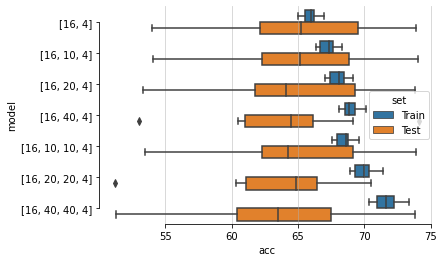

In [ ]:
def evaluate_model_cross(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training/testing in a "leave-one-participant-out" fashion

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates to leave out
    overall_acc_train = []
    overall_acc_test  = []
    for leave_out in range(1,11,1) :
        print("Person {} is left out".format(leave_out), end = "\r")
        model.reset_parameters()
        
        keys_test  = ["p{}_d1".format(leave_out),"p{}_d2".format(leave_out)]
        keys_train = [k  for k in dfs.keys() if k not in keys_test]
                 
        loader_train = create_dataloader({key : dfs[key] for key in keys_train},BATCH_SIZE,)
        loader_test  = create_dataloader({key : dfs[key] for key in keys_test} ,BATCH_SIZE,)
        
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_train,optim, verbose = False)
        acc_test = test_epoch(model,loader_test, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_performances_cross(models : list):
    """Wraps the evaluate_model function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
          }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = evaluate_model_cross(mod,5,dfs)
            print('"{}" : ({},{}),'.format(mod.description(), overall_acc_train, overall_acc_test) )
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_performances_cross(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
        Linear_Model(num_hidden=[20]),
        Linear_Model(num_hidden=[40]),
        Linear_Model(num_hidden=[10,10]),
        Linear_Model(num_hidden=[20,20]),
        Linear_Model(num_hidden=[40,40]),
    ])

Model: [16, 4]
Model: [16, 10, 4]
Model: [16, 20, 4]
Model: [16, 40, 4]
Model: [16, 10, 10, 4]
Model: [16, 20, 20, 4]
Model: [16, 40, 40, 4]


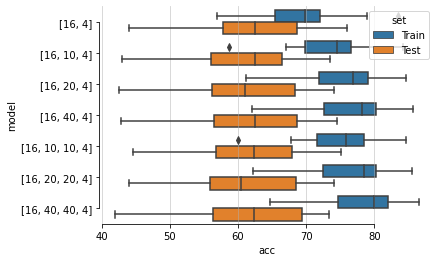

In [ ]:
def model_in_person_accuracy(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training/testing on one day of a person and predicting the other day.
    Per person has to experiments: d1→d2 and d2→d1

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates 
    overall_acc_train = []
    overall_acc_test  = []
    for person in range(1,11,1) :
        print("Person {}".format(person), end = "\r")
       
        loader_d1  = create_dataloader({"p{}_d1".format(person) : dfs["p{}_d1".format(person)]},BATCH_SIZE,)
        loader_d2  = create_dataloader({"p{}_d2".format(person) : dfs["p{}_d2".format(person)]},BATCH_SIZE,)
        
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_d1,optim, verbose = False)
        acc_test = test_epoch(model,loader_d2, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_d2,optim, verbose = False)
        acc_test = test_epoch(model,loader_d1, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_performances_in_person(models : list):
    """Wraps the model_in_person_accuracy function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
        }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = model_in_person_accuracy(mod,5,dfs)
            print('"{}" : ({},{}),'.format(mod.description(), overall_acc_train, overall_acc_test) )
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_performances_in_person(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
         Linear_Model(num_hidden=[20]),
         Linear_Model(num_hidden=[40]),
         Linear_Model(num_hidden=[10,10]),
         Linear_Model(num_hidden=[20,20]),
         Linear_Model(num_hidden=[40,40]),
    ])

Model: [16, 4]
Model [16, 4] Acc Mean:  Train: 69.07    Test: 61.44
[71.69578134284016, 71.37948412516609, 71.32725917734452, 70.89258563634738, 66.81722712798393, 64.35987865933362, 73.55222460147513, 78.84153594111179, 65.62574664309265, 58.42425741044107, 61.188399593343675, 64.93193743821136, 56.787684762618355, 65.86568824997744, 77.30541793191625, 72.44684474285992, 66.89397070303531, 68.77363030178043, 70.86736030094521, 83.38220918866081]
[62.30127823338067, 68.52287581699346, 65.9042125033539, 64.21376541577519, 57.178089624386516, 66.8398111971815, 75.7714490899706, 69.13395193909112, 50.8144530646308, 49.115974578295976, 61.8798955613577, 57.70506715180053, 46.69934738804848, 43.55289149240515, 71.69756239964968, 72.51535423183178, 59.88863683233656, 57.25536116085779, 69.78773914257785, 58.10814028237423]

Model: [16, 10, 4]
Model [16, 10, 4] Acc Mean:  Train: 73.98    Test: 61.68
[76.97207367795603, 75.35850093920374, 75.51265716277616, 73.84849297916108, 68.37326949569773

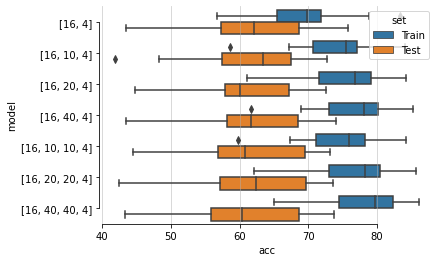

In [ ]:
def model_calibration_accuracy(model : torch.nn.Module, num_epochs, dfs = None, optim_kwargs = {"lr" : 1e-2, "weight_decay" : 1e-5}):
    """Evaluates a model, by training it on the entire dataset except one. This includes also the other day by the same person. 
    Per person has to experiments: d1→d2 and d2→d1

    Args:
        model (torch.nn.Module)
    """
    if dfs is None:
        dfs = preprocess_dataset( "condensed", 100, overlapping=False, )
    
    # Iterate over all candidates 
    overall_acc_train = []
    overall_acc_test  = []
    for person in range(1,11,1) :
        print("Person {}".format(person), end = "\r")
       
        loader_d1  = create_dataloader({"p{}_d1".format(person) : dfs["p{}_d1".format(person)]},BATCH_SIZE,)
        loader_d2  = create_dataloader({"p{}_d2".format(person) : dfs["p{}_d2".format(person)]},BATCH_SIZE,)
        
        keys_not_d1 = [k  for k in dfs.keys() if k != "p{}_d1"]
        keys_not_d2 = [k  for k in dfs.keys() if k != "p{}_d2"]
                
        loader_not_d1 = create_dataloader({key : dfs[key] for key in keys_not_d1},BATCH_SIZE,)
        loader_not_d2 = create_dataloader({key : dfs[key] for key in keys_not_d2},BATCH_SIZE,)
        

        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_not_d2,optim, verbose = False)
        acc_test = test_epoch(model,loader_d2, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        
        # Day1 -> Day2
        
        model.reset_parameters()
        optim = torch.optim.Adam(model.parameters(),**optim_kwargs)
        
        for epoch in range(num_epochs):
            acc_train = train_epoch(model,loader_not_d1,optim, verbose = False)
        acc_test = test_epoch(model,loader_d1, verbose = False)   
        
        overall_acc_train.append(acc_train)
        overall_acc_test .append(acc_test)
        

    print("Model {} Acc Mean:  Train: {:.2f}    Test: {:.2f}".format(model.description(), sum(overall_acc_train)/len(overall_acc_train), sum(overall_acc_test)/len(overall_acc_test) ))
    return (overall_acc_train, overall_acc_test)

def show_model_calibration(models : list):
    """Wraps the model_in_person_accuracy function to pass it multiple models at once and produce a nice plot from it

    Args:
        models (list): list of models
    """
    LOG_SAVES = {
      }
    
    logging = pd.DataFrame(columns= ["model", "acc", "set"])
    
    for mod in models:
        if mod.description() in LOG_SAVES:
            overall_acc_train, overall_acc_test = LOG_SAVES[mod.description()]
            
        else:
            overall_acc_train, overall_acc_test = model_in_person_accuracy(mod,5,dfs)
            print('"{}" : ({},{}),'.format(mod.description(), overall_acc_train, overall_acc_test) )
        logging = pd.concat([logging, 
        
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_train],
                "acc" : overall_acc_train,
                "set" : ["Train" for _ in overall_acc_train]
            }),
            pd.DataFrame({
                "model" : [mod.description() for _ in overall_acc_test],
                "acc" : overall_acc_test,
                "set" : ["Test" for _ in overall_acc_test]
            })
        ])
    
    sns.boxplot(data=logging, x="acc", y="model", hue="set")
    #sns.stripplot(data=logging, x="acc", y="model", hue="set")
    sns.despine(trim = True)
    
    plt.grid(axis = "x", alpha = 0.6)
    plt.show()
    

show_model_calibration(models = [
        Linear_Model(num_hidden=[]),
        Linear_Model(num_hidden=[10]),
         Linear_Model(num_hidden=[20]),
         Linear_Model(num_hidden=[40]),
         Linear_Model(num_hidden=[10,10]),
         Linear_Model(num_hidden=[20,20]),
         Linear_Model(num_hidden=[40,40]),
    ])